## SQL Agent with Dedicated Tools using create_agent
**Key Features:**
- Agent-based SQL query generation with autonomous tool usage
- SQLite database integration with employees database
- Safety validation system to prevent destructive SQL operations
- Automatic error detection and query correction capabilities
- Interactive chat interface for natural language database queries

In [ ]:
# https://github.com/fracpete/employees-db-sqlite

In [ ]:
"""
SQL Agent with Dedicated Tools using create_agent
Using employees db database with create_agent approach
"""

import re

# Core imports
from langchain_ollama import ChatOllama
from langchain_community.utilities import SQLDatabase
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langchain.agents import create_agent

from dotenv import load_dotenv
load_dotenv()


True

In [ ]:
# ============================================================================
# STEP 1: DATABASE SETUP
# ============================================================================
print("Setting up employees database...")


# Connect to employees database
db = SQLDatabase.from_uri("sqlite:///db/employees_db-full-1.0.6.db")

# Check connection and get basic info
try:
    # Test connection by getting table names
    tables = db.get_usable_table_names()
    print(f"✓ Database connected successfully")
    print(f"✓ Found {len(tables)} tables: {', '.join(tables)}")
    
except Exception as e:
    print(f"✗ Database connection failed: {e}")

# Get schema information
SCHEMA = db.get_table_info()
# print("\nDatabase Schema:", SCHEMA)
print("✓ Connected to employees database")


Setting up employees database...
✓ Database connected successfully
✓ Found 6 tables: departments, dept_emp, dept_manager, employees, salaries, titles
✓ Connected to employees database


In [3]:

# ============================================================================
# STEP 2: MODELS SETUP
# ============================================================================
# Using ChatOllama
llm = ChatOllama(
    model="qwen3", 
    base_url="http://localhost:11434",
    temperature=0
)

response = llm.invoke("Hello, how are you?")
response.pretty_print()
print("✓ Initialized Ollama chat model")


================================== Ai Message ==================================

Hello! I'm just a chatbot, so I don't have feelings, but I'm here and ready to help! 😊 How can I assist you today? Whether you have questions, need advice, or just want to chat, I'm all ears! What's on your mind?
✓ Initialized Ollama chat model


In [4]:

# ============================================================================
# STEP 3: SQL TOOLS - One for each step
# ============================================================================

@tool
def get_database_schema(table_name: str = None) -> str:
    """Get database schema information for SQL query generation.
    Use this first to understand table structure before creating queries."""
    print(f"🔍 Getting schema for: {table_name if table_name else 'all tables'}")
    
    if table_name:
        try:
            # Get specific table info
            tables = db.get_usable_table_names()
            if table_name.lower() in [t.lower() for t in tables]:
                result = db.get_table_info([table_name])
                print(f"✓ Retrieved schema for table: {table_name}")
                return result
            else:
                return f"Error: Table '{table_name}' not found. Available tables: {', '.join(tables)}"
        except Exception as e:
            return f"Error getting table info: {e}"
    else:
        # Get all schema info
        print("✓ Retrieved full database schema")
        return SCHEMA


In [5]:

@tool
def generate_sql_query(question: str, schema_info: str = None) -> str:
    """Generate a SQL SELECT query from a natural language question using database schema.
    Always use this after getting schema information."""
    print(f"🔧 Generating SQL for: {question[:100]}...")
    
    # Use provided schema or get full schema
    schema_to_use = schema_info if schema_info else SCHEMA
    
    prompt = f"""
                Based on this database schema:
                {schema_to_use}

                Generate a SQL query to answer this question: {question}

                Rules:
                - Use only SELECT statements
                - Include only existing columns and tables
                - Add appropriate WHERE, GROUP BY, ORDER BY clauses as needed
                - Limit results to 10 rows unless specified otherwise
                - Use proper SQL syntax for SQLite

                Return only the SQL query, nothing else.
                """
    
    try:
        response = llm.invoke(prompt)
        query = response.content.strip()
        print(f"✓ Generated SQL query")
        return query
    except Exception as e:
        return f"Error generating query: {e}"


In [ ]:
@tool
def validate_sql_query(query: str) -> str:
    """Validate SQL query for safety and syntax before execution.
    Returns 'Valid: <query>' if safe or 'Error: <message>' if unsafe."""
    print(f"🔍 Validating SQL: {query[:100]}...")
    
    # Clean up the query
    clean_query = query.strip()
    
    # Remove SQL code block markers if present
    clean_query = re.sub(r'```sql\s*', '', clean_query, flags=re.IGNORECASE)
    clean_query = re.sub(r'```\s*', '', clean_query)
    clean_query = clean_query.strip().rstrip(";")
    
    # Check 1: Must be a SELECT statement
    if not clean_query.lower().startswith("select"):
        return "Error: Only SELECT statements are allowed"
    
    # Check 2: Block dangerous SQL keywords
    dangerous_keywords = ['INSERT', 'UPDATE', 'DELETE', 'ALTER', 'DROP', 'CREATE', 'TRUNCATE']
    query_upper = clean_query.upper()
    
    for keyword in dangerous_keywords:
        if keyword in query_upper:
            return f"Error: {keyword} operations are not allowed"
    
    print("✓ Query validation passed")
    return f"Valid: {clean_query}"

In [7]:

@tool
def execute_sql_query(query: str) -> str:
    """Execute a validated SQL query and return results.
    Only use this after validating the query for safety."""
    print(f"🚀 Executing SQL: {query[:100]}...")
    
    try:
        # Clean the query
        clean_query = query.strip()
        if clean_query.startswith("Valid: "):
            clean_query = clean_query[7:]  # Remove "Valid: " prefix
        
        clean_query = re.sub(r'```sql\s*', '', clean_query, flags=re.IGNORECASE)
        clean_query = re.sub(r'```\s*', '', clean_query)
        clean_query = clean_query.strip().rstrip(";")
        
        # Execute query
        result = db.run(clean_query)
        print("✓ Query executed successfully")
        
        if result:
            return f"Query Results:\n{result}"
        else:
            return "Query executed successfully but returned no results."
            
    except Exception as e:
        error_msg = f"Execution Error: {str(e)}"
        print(f"✗ {error_msg}")
        return error_msg


In [8]:
@tool
def fix_sql_error(original_query: str, error_message: str, question: str) -> str:
    """Fix a failed SQL query by analyzing the error and generating a corrected version.
    Use this when validation or execution fails."""
    print(f"🔧 Fixing SQL error: {error_message[:100]}...")
    
    fix_prompt = f"""
                    The following SQL query failed:
                    Query: {original_query}
                    Error: {error_message}
                    Original Question: {question}

                    Database Schema:
                    {SCHEMA}

                    Analyze the error and provide a corrected SQL query that:
                    1. Fixes the specific error mentioned
                    2. Still answers the original question
                    3. Uses only valid table and column names from the schema
                    4. Follows SQLite syntax rules

                    Return only the corrected SQL query, nothing else.
                    """
    
    try:
        response = llm.invoke(fix_prompt)
        fixed_query = response.content.strip()
        print("✓ Generated fixed SQL query")
        return fixed_query
    except Exception as e:
        return f"Error generating fix: {e}"


In [9]:
print("✓ Created all SQL workflow tools")

✓ Created all SQL workflow tools


In [10]:
# ============================================================================
# STEP 4: SYSTEM PROMPT
# ============================================================================

SQL_SYSTEM_PROMPT = f"""You are an expert SQL analyst working with an employees database.

Database Schema:
{SCHEMA}

Your workflow for answering questions:
1. Use `get_database_schema` first to understand available tables and columns (if needed)
2. Use `generate_sql_query` to create SQL based on the question
3. Use `validate_sql_query` to check the query for safety and syntax
4. Use `execute_sql_query` to run the validated query
5. If there's an error, use `fix_sql_error` to correct it and try again (up to 3 times)
6. Provide a clear answer based on the query results

Rules:
- Always follow the workflow step by step
- If a query fails, use the fix tool and try again
- Provide clear, informative answers
- Be precise with table and column names
- Handle errors gracefully and try to fix them
- If you fail after 3 attempts, explain what went wrong

Available tools for each step:
- get_database_schema: Get table structure info
- generate_sql_query: Create SQL from question
- validate_sql_query: Check query safety/syntax  
- execute_sql_query: Run the query
- fix_sql_error: Fix failed queries

Remember: Always validate queries before executing them for safety.
"""

In [11]:
# ============================================================================
# STEP 5: CREATE AGENT
# ============================================================================

# All tools for the agent
tools = [
    get_database_schema,
    generate_sql_query,
    validate_sql_query, 
    execute_sql_query,
    fix_sql_error
]

# Create the SQL agent using create_agent
sql_agent = create_agent(
    llm, 
    tools, 
    system_prompt=SQL_SYSTEM_PROMPT
)

print("✓ Created SQL agent with create_agent")

✓ Created SQL agent with create_agent


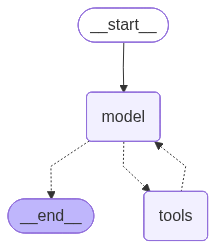

In [12]:
sql_agent

In [ ]:

# ============================================================================
# STEP 6: QUERY FUNCTIONS 
# ============================================================================

def ask_sql(question: str):
    """Ask the SQL agent a question using the full workflow."""
    print(f"\n{'='*60}")
    print(f"SQL AGENT - Question: {question}")
    print('='*60)
    
    for event in sql_agent.stream({"messages": question},stream_mode="values"):
        msg = event["messages"][-1]
        
        # Show tool usage
        if hasattr(msg, 'tool_calls') and msg.tool_calls:
            for tc in msg.tool_calls:
                print(f"\n🔧 Using Tool: {tc['name']}")
                print(f"Args: {str(tc['args'])[:200]}...")
        
        # Show final answer
        elif hasattr(msg, 'content') and msg.content:
            print(f"\n💬 Answer:\n{msg.content}")


In [16]:
ask_sql("List the first 5 employees with maximum salary.")


SQL AGENT - Question: List the first 5 employees with maximum salary.

💬 Answer:
List the first 5 employees with maximum salary.

🔧 Using: generate_sql_query
Args: {'question': 'List the first 5 employees with maximum salary.', 'schema_info': 'Tables: employees (emp_no, birth_date, first_name, last_name, gender, hire_date), salaries (emp_no, salary, from_date, t...
🔧 Generating SQL for: List the first 5 employees with maximum salary....
✓ Generated SQL query

💬 Answer:
SELECT e.first_name, e.last_name, s.salary
FROM employees e
JOIN salaries s ON e.emp_no = s.emp_no
ORDER BY s.salary DESC
LIMIT 5;

🔧 Using: validate_sql_query
Args: {'query': 'SELECT e.first_name, e.last_name, s.salary\nFROM employees e\nJOIN salaries s ON e.emp_no = s.emp_no\nORDER BY s.salary DESC\nLIMIT 5;'}
🔍 Validating SQL: SELECT e.first_name, e.last_name, s.salary
FROM employees e
JOIN salaries s ON e.emp_no = s.emp_no
O...
✓ Query validation passed

💬 Answer:
Valid: SELECT e.first_name, e.last_name, s.salary
FR